In [10]:
''' imports '''

# plotting with matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import random


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

from solar_module import SolarModule, generate_shading
from string_to_embedding import string_to_embedding

import pandas

[[1.         0.08479421 1.         0.38648363 1.         0.63341
  1.         1.         0.72480497 0.41704269 1.         1.
  1.         0.47035792 1.         1.        ]
 [1.         0.60346863 0.69179263 0.85943205 1.         0.80945606
  1.         1.         1.         1.         1.         1.
  1.         1.         0.48942727 1.        ]
 [0.67555665 1.         1.         1.         0.43102796 1.
  0.76705267 1.         0.80524996 1.         1.         1.
  1.         1.         0.40525798 1.        ]
 [0.88320748 1.         0.36400685 1.         0.62902701 1.
  1.         1.         1.         0.06760475 0.67392958 1.
  0.63672962 0.13017189 0.38987651 1.        ]
 [1.         1.         1.         1.         1.         0.43014697
  0.57939927 0.44065353 0.90665765 0.67006059 0.12263469 1.
  0.96663279 1.         1.         1.        ]
 [0.81047191 1.         0.73273044 1.         1.         1.
  1.         1.         1.         1.         0.11919695 1.
  1.         0.77090821 

In [75]:
''' build 'image' dataset (shading maps as 2d array) as list '''
l = []
for x in range(10000):
    array = generate_shading(3, 1, 12, 12)
    array = np.pad(array, 2)
    l.append(array)

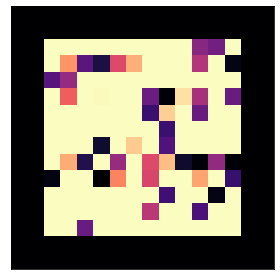

In [76]:
''' select cell image by label '''

_cell = l[0]

# diplay images
_w = 4; _h = 4; fig = plt.figure(figsize = (_w, _h))
ax = []; ax.append(fig.add_subplot(111))#; ax.append(fig.add_subplot(122))

ax[0].imshow(_cell, cmap = 'magma')

ax[0].set_xticks([]); ax[0].set_yticks([])

plt.tight_layout()
plt.show()


In [77]:
from torch.utils.data import Dataset

''' dataset components '''

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)
    

In [78]:
''' reshape, convert to tensors, init dataset '''

# init random with seed
#random.seed(252)

# inplace shuffle dataset (augmentations)
#random.shuffle(data)

# stack and reshape cell image dataset (n images, 1 channel, width, height)
#__data = np.stack(_data).reshape(len(_data),1,_data[0].shape[0],_data[0].shape[1])
#__data.shape

# list of tensors, reshaped with 1 channel
_data = [ torch.Tensor(_.reshape(1,_.shape[0],_.shape[1])) for _ in l ]

# initialise custom dataset from cell images
dataset = CustomDataset(_data, list(range(len(_data))))

In [79]:
list(_data[0].shape[1:])

[16, 16]

In [80]:
_data[0].shape

torch.Size([1, 16, 16])

In [81]:
''' use cuda else cpu for compute '''

# check available compute device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [82]:
''' define cnn vae model '''

class VAE(nn.Module):
    #def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=64):
    def __init__(self, imgChannels=1, fDim=8, kern=3, zDim=32, imgShape = (16,16)):
        super(VAE, self).__init__()
        
        self.fDim = fDim
        self.imgShape = imgShape
        self.featureDim = 2*self.fDim*(self.imgShape[0])*(self.imgShape[1])#*4//kern
        
        #self.featureDim = _in - (kern-1)-1
        
        #self.featureDim = 2*self.fDim*20*20
        #print(self.featureDim)
        
        self.pad = (kern-1)//2

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, fDim, kern, padding = self.pad ) # (in_channels, out_channels, kernel)
        #self.encConv2 = nn.Conv2d(fDim, 2*fDim, kern, padding = 'same')
        self.encConv2 = nn.Conv2d(fDim, 2*fDim, kern, padding = self.pad )
        self.encFC1 = nn.Linear(self.featureDim, zDim)
        self.encFC2 = nn.Linear(self.featureDim, zDim)
        
        # 6 conv layers, 6 -> 16 -> 32 -> 64 -> 32 -> 16 ->(linear) -> ... -> 10,800
        
        # embedding dimensions are (10, 6, 10, 6, 3) 10,800 nodes or (60, 60, 3)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, self.featureDim)
        self.decConv1 = nn.ConvTranspose2d(2*fDim, fDim, kern, padding = self.pad )
        self.decConv2 = nn.ConvTranspose2d(fDim, imgChannels, kern, padding = self.pad )

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        #print('enc ', x.shape)
        x = F.relu(self.encConv1(x))
        #print('conv1 ', x.shape)
        x = F.relu(self.encConv2(x))
        #print('conv2 ', x.shape)
        x = x.view(-1, self.featureDim)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        #print('dec ', x.shape)
        x = x.view(-1, 2*self.fDim, self.imgShape[0], self.imgShape[1])
        #x = x.view(-1, 2*self.fDim, 20, 20)
        #print('decv ', x.shape)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar
    

In [83]:
""" Initialize Hyperparameters """

# init hyper params
batch_size = 32 # 32-64 is advisable
learning_rate = 1e-3 # sensitivity of gradient descent
num_epochs = 1 # iterations over entire dataset 


In [84]:
""" Create dataloaders to feed data into the neural network """

## note: better to split dataset into ~80:20 train:test, below simply entire dataset

# training dataset
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# test/validation dataset
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1)


torch.Size([1, 16, 16])


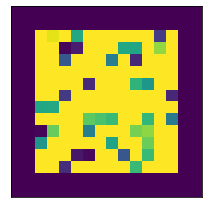

tensor(2998)


In [85]:
""" Check image dataset """
    
# get single random image batch from test dataset
for d in random.sample(list(test_loader), 1):

    # unpack image data, label from sample
    imgs, _ = d

    # push images to gpu
    imgs = imgs.to(device)

    print(imgs[0].shape)

    # get single image from gpu
    img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])

    plt.figure(figsize = (3,3))

    # plot input image
    plt.subplot(111)
    plt.imshow(np.squeeze(img))
    plt.xticks([]); plt.yticks([])


    plt.tight_layout()
    plt.show()

    print(_[0])

    break
        

In [86]:
""" Initialize the network """

# init vae model
#net = VAE().to(device)

# init model with specified hyperparams
#net = VAE(fDim=16, kern=(1), zDim=32, imgShape=(25,25)).to(device)
net = VAE().to(device)


In [87]:
""" Initialize the Adam optimizer """

# init adam optimiser
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


In [88]:
net.encConv1.bias.data

tensor([ 0.2065, -0.0701,  0.1090, -0.2831,  0.0065,  0.2584,  0.1136, -0.2713])

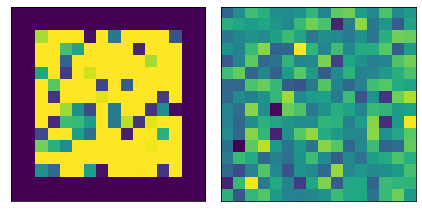

tensor(6474)


In [90]:
"""
The following part takes a random image from test loader to feed into the VAE.
Both the original image and generated image from the distribution are shown.
"""

# set model eval state
net.eval()

# without compute gradients
with torch.no_grad():
    
    # get single random image batch from test dataset
    for d in random.sample(list(test_loader), 1):
        
        # unpack image data, label from sample
        imgs, _ = d
        
        # push images to gpu
        imgs = imgs.to(device)
        
        # get single image from gpu
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        
        plt.figure(figsize = (6,3))
        
        # plot input image
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        plt.xticks([]); plt.yticks([])
        
        # compute output image
        out, mu, logVAR = net(imgs)
        
        # get output image from gpu, reshape
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        
        # plot output image
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        plt.xticks([]); plt.yticks([])
        
        plt.tight_layout()
        plt.show()
        
        print(_[0])
        
        break
        

In [101]:
"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""

# set train state
net.train()

num_epochs = 100

# iterate over epochs
for epoch in range(num_epochs):
    
    # iterate over training dataset by batch
    for idx, d in enumerate(train_loader, 0):
        
        # unpack batch images and labels
        imgs, _ = d
        
        # push images to gpu
        imgs = imgs.to(device)
        
        #print('batch ',imgs.shape)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(imgs)
        
        #print('out ', out.shape)

        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(out, _)
        #loss = (optimised power value from labels - observed power)^2 for supervised model

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch {}: Loss {}'.format(epoch, loss))

Epoch 0: Loss 1043.2412109375
Epoch 1: Loss 1024.7623291015625
Epoch 2: Loss 1047.15673828125
Epoch 3: Loss 1048.8431396484375
Epoch 4: Loss 1015.9406127929688
Epoch 5: Loss 1032.203369140625
Epoch 6: Loss 1019.0953369140625
Epoch 7: Loss 1018.7611694335938
Epoch 8: Loss 1005.8056640625
Epoch 9: Loss 1064.1639404296875
Epoch 10: Loss 1049.5447998046875
Epoch 11: Loss 1013.2725830078125
Epoch 12: Loss 1027.72265625
Epoch 13: Loss 1028.1796875
Epoch 14: Loss 1036.0330810546875
Epoch 15: Loss 1006.1487426757812
Epoch 16: Loss 1020.04541015625
Epoch 17: Loss 1027.6861572265625
Epoch 18: Loss 1032.3779296875
Epoch 19: Loss 1054.9027099609375
Epoch 20: Loss 1035.2137451171875
Epoch 21: Loss 1031.95263671875
Epoch 22: Loss 1029.55078125
Epoch 23: Loss 1060.551513671875
Epoch 24: Loss 1063.203125
Epoch 25: Loss 1084.8900146484375
Epoch 26: Loss 1023.0577392578125
Epoch 27: Loss 1005.277099609375
Epoch 28: Loss 1011.7184448242188
Epoch 29: Loss 1038.37353515625
Epoch 30: Loss 1024.9915771484375

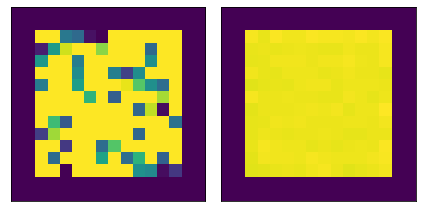

tensor(2818)


In [98]:
"""
The following part takes a random image from test loader to feed into the VAE.
Both the original image and generated image from the distribution are shown.
"""

# set model eval state
net.eval()

# without compute gradients
with torch.no_grad():
    
    # get single random image batch from test dataset
    for d in random.sample(list(test_loader), 1):
        
        # unpack image data, label from sample
        imgs, _ = d
        
        # push images to gpu
        imgs = imgs.to(device)
        
        # get single image from gpu
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        
        plt.figure(figsize = (6,3))
        
        # plot input image
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        plt.xticks([]); plt.yticks([])
        
        # compute output image
        out, mu, logVAR = net(imgs)
        
        # get output image from gpu, reshape
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        
        # plot output image
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        plt.xticks([]); plt.yticks([])
        
        plt.tight_layout()
        plt.show()
        
        print(_[0])
        
        break
        

In [94]:
''' save model checkpoint '''

# set model checkpoint path inc. hyperparams
_path = '../data/model/cnn-vae-f{}-k{}-z{}-i{}-v{}.pth'.format(8,3,256,115,'01')

torch.save({
            #'epoch': epoch,
            #'model_state_dict': model.state_dict(),
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            #'loss': loss,
}, _path)


FileNotFoundError: [Errno 2] No such file or directory: '../data/model/cnn-vae-f8-k3-z256-i115-v01.pth'

In [19]:
''' load model checkpoint from file '''

# init model and optimiser
#model = TheModelClass(*args, **kwargs)
#optimizer = TheOptimizerClass(*args, **kwargs)

#_path = '../data/model/cnn-vae-f16-k5-z128-i121-v01.pth'
#_path = '../data/model/cnn-vae-f16-k3-z128-i115-v01.pth'
_path = '../data/model/cnn-vae-f8-k3-z256-i115-v01.pth'

# load checkpoint
checkpoint = torch.load(_path)

# update model
#model.load_state_dict(checkpoint['model_state_dict'])
net.load_state_dict(checkpoint['model_state_dict'])

# update optimiser
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# set epoch and loss
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']

# set model train/eval state
#model.eval()
#model.train()